# Horn Antenna Design for Hydrogen Line (1.42 GHz)

This notebook provides a starting point for designing a horn antenna tuned for the hydrogen line frequency at 1.42 GHz using OpenEMS.

## About the Project

The hydrogen line (21 cm line) is at 1420.405751 MHz and is used in radio astronomy to detect neutral hydrogen in space.

## Prerequisites

Before running this notebook, ensure you have:
1. OpenEMS installed on your system (see https://docs.openems.de/install.html)
2. Python dependencies installed: `pip install -r requirements.txt`

## References

- OpenEMS Documentation: https://docs.openems.de/
- OpenEMS Python Examples: https://github.com/thliebig/openEMS-Project

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import sys

# Set up matplotlib for inline plotting
%matplotlib inline

print("Basic imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Basic imports successful!
NumPy version: 2.4.0
Matplotlib version: 3.10.8


In [2]:
# Try to import OpenEMS
# Note: This will fail if OpenEMS is not installed
try:
    from CSXCAD import CSXCAD
    from openEMS import openEMS
    from openEMS.physical_constants import C0, EPS0, MUE0
    print("✓ OpenEMS imported successfully!")
    openems_available = True
except ImportError as e:
    print("✗ OpenEMS not found. Please install OpenEMS first.")
    print(f"  Error: {e}")
    print("\nInstallation instructions:")
    print("  Visit: https://docs.openems.de/install.html")
    openems_available = False

✓ OpenEMS imported successfully!


## Design Parameters

Let's define the basic parameters for our **conical horn antenna** design.

In [13]:
# Hydrogen line frequency (21 cm line)
f0 = 1420.405751e6  # 1420.405751 MHz in Hz (precise hydrogen line frequency)
wavelength = 3e8 / f0  # Wavelength in meters

print(f"Design frequency: {f0/1e9:.6f} GHz ({f0/1e6:.6f} MHz)")
print(f"Wavelength (λ): {wavelength*1000:.2f} mm ({wavelength*100:.2f} cm)")

# Conical horn antenna parameters
# For circular waveguide: TE11 mode cutoff diameter ≈ 0.586λ
waveguide_diameter = 0.65 * wavelength  # Slightly above cutoff for TE11 mode
horn_length = 3 * wavelength            # Axial length of the horn
aperture_diameter = 2.5 * wavelength    # Output aperture diameter

# Calculate half-angle of the cone
flare_angle = np.arctan((aperture_diameter - waveguide_diameter) / (2 * horn_length)) * 180 / np.pi

print(f"\nConical Horn Dimensions:")
print(f"  Waveguide diameter: {waveguide_diameter*1000:.1f} mm ({waveguide_diameter/wavelength:.2f}λ)")
print(f"  Aperture diameter: {aperture_diameter*1000:.1f} mm ({aperture_diameter/wavelength:.2f}λ)")
print(f"  Length: {horn_length*1000:.1f} mm ({horn_length/wavelength:.1f}λ)")
print(f"  Flare angle: {flare_angle:.2f}°")

Design frequency: 1.420406 GHz (1420.405751 MHz)
Wavelength (λ): 211.21 mm (21.12 cm)

Conical Horn Dimensions:
  Waveguide diameter: 137.3 mm (0.65λ)
  Aperture diameter: 528.0 mm (2.50λ)
  Length: 633.6 mm (3.0λ)
  Flare angle: 17.14°


## Conical Horn Antenna Geometry Visualization

Let's visualize the conical horn antenna geometry before simulation.

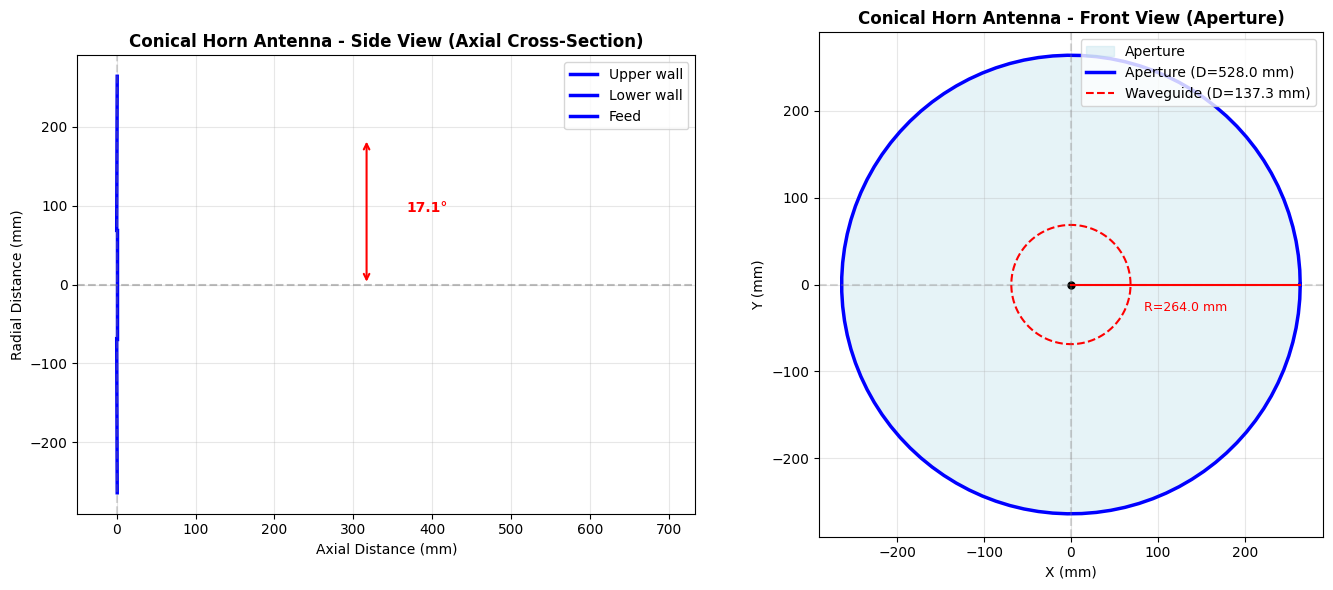


Conical Horn Specifications:
  Waveguide diameter: 137.3 mm
  Aperture diameter: 528.0 mm
  Axial length: 633.6 mm
  Flare angle: 17.14°
  Slant length: 663.1 mm


In [ ]:
# Create visualization of the conical horn antenna
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Side view (cross-section through axis)
ax1.set_title('Conical Horn Antenna - Side View (Axial Cross-Section)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Axial Distance (mm)')
ax1.set_ylabel('Radial Distance (mm)')

# Draw conical horn outline
ax1.plot([0, horn_length*1e3], [waveguide_diameter/2 * 1e3, aperture_diameter/2 * 1e3], 'b-', linewidth=2.5, label='Upper wall')
ax1.plot([0, horn_length*1e3], [-waveguide_diameter/2 * 1e3, -aperture_diameter/2 * 1e3], 'b-', linewidth=2.5, label='Lower wall')
ax1.plot([0, 0], [-waveguide_diameter/2 * 1e3, waveguide_diameter/2 * 1e3], 'b-', linewidth=2.5, label='Feed')
ax1.plot([horn_length*1e3, horn_length*1e3], [-aperture_diameter/2 * 1e3, aperture_diameter/2 * 1e3], 'b-', linewidth=2.5, label='Aperture')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add annotations
ax1.annotate('', xy=(horn_length*1e3/2, aperture_diameter/2*1e3*0.7), 
             xytext=(horn_length*1e3/2, 0),
             arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax1.text(horn_length*1e3/2 + 50, aperture_diameter/4*1e3*0.7, 
         f'{flare_angle:.1f}°', color='red', fontsize=10, fontweight='bold')

ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax1.set_xlim(-50, horn_length*1e3 + 100)
ax1.legend(loc='upper right')

# Front view (aperture view)
ax2.set_title('Conical Horn Antenna - Front View (Aperture)', fontsize=12, fontweight='bold')
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')

# Draw circular aperture
theta = np.linspace(0, 2*np.pi, 100)
aperture_x = (aperture_diameter/2) * np.cos(theta) * 1e3
aperture_y = (aperture_diameter/2) * np.sin(theta) * 1e3
waveguide_x = (waveguide_diameter/2) * np.cos(theta) * 1e3
waveguide_y = (waveguide_diameter/2) * np.sin(theta) * 1e3

ax2.fill(aperture_x, aperture_y, color='lightblue', alpha=0.3, label='Aperture')
ax2.plot(aperture_x, aperture_y, 'b-', linewidth=2.5, label=f'Aperture (D={aperture_diameter*1000:.1f} mm)')
ax2.plot(waveguide_x, waveguide_y, 'r--', linewidth=1.5, label=f'Waveguide (D={waveguide_diameter*1000:.1f} mm)')

# Add center point and axis indicators
ax2.plot(0, 0, 'ko', markersize=5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add diameter annotation
ax2.plot([0, aperture_diameter/2*1e3], [0, 0], 'r-', linewidth=1.5)
ax2.text(aperture_diameter/4*1e3, -30, f'R={aperture_diameter/2*1000:.1f} mm', 
         color='red', fontsize=9, ha='center')

ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nConical Horn Specifications:")
print(f"  Waveguide diameter: {waveguide_diameter*1000:.1f} mm")
print(f"  Aperture diameter: {aperture_diameter*1000:.1f} mm")
print(f"  Axial length: {horn_length*1000:.1f} mm")
print(f"  Flare angle: {flare_angle:.2f}°")
print(f"  Slant length: {np.sqrt(horn_length**2 + ((aperture_diameter-waveguide_diameter)/2)**2)*1000:.1f} mm")

## OpenEMS Simulation Setup

This section will set up an OpenEMS simulation for the horn antenna.

**Note:** This requires OpenEMS to be properly installed on your system.

In [5]:
if openems_available:
    print("Setting up OpenEMS simulation...")
    
    # Create simulation directory
    sim_path = os.path.join(os.getcwd(), 'horn_antenna_sim')
    os.makedirs(sim_path, exist_ok=True)
    print(f"Simulation directory: {sim_path}")
    
    # Unit conversion to mm (OpenEMS often works in mm)
    unit = 1e-3  # Coordinates in mm
    
    # Initialize FDTD and CSX
    FDTD = openEMS(NrTS=50000, EndCriteria=1e-4)
    FDTD.SetGaussExcite(f0, f0/10)  # Center frequency and bandwidth
    FDTD.SetBoundaryCond(['PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8'])  # PML boundary
    
    CSX = CSXCAD.ContinuousStructure()
    FDTD.SetCSX(CSX)
    
    print("✓ OpenEMS initialized")
    print("\nSimulation Parameters:")
    print(f"  Center frequency: {f0/1e9:.3f} GHz")
    print(f"  Max timesteps: 50000")
    print(f"  End criteria: 1e-4")
    print(f"  Boundary: 8-layer PML")
else:
    print("⚠ OpenEMS not available. Skipping simulation setup.")
    print("Install OpenEMS to run electromagnetic simulations.")

Setting up OpenEMS simulation...
Simulation directory: /home/kaitlyn/Workspaces/hydrogen-line-horn-antenna/horn_antenna_sim
✓ OpenEMS initialized

Simulation Parameters:
  Center frequency: 1.420 GHz
  Max timesteps: 50000
  End criteria: 1e-4
  Boundary: 8-layer PML


## Mesh Configuration

A proper mesh is crucial for accurate simulations. The mesh resolution should be fine enough to capture the geometry and field variations.

In [6]:
if openems_available:
    # Mesh resolution
    mesh_res = wavelength / 20  # λ/20 is a good starting point
    
    print(f"Mesh resolution: {mesh_res*1000:.2f} mm (λ/{wavelength/mesh_res:.0f})")
    
    # Define mesh
    mesh = CSX.GetGrid()
    mesh.SetDeltaUnit(unit)
    
    # Simulation domain (with air space around antenna)
    air_space = 2 * wavelength  # Air space around antenna
    
    # Create mesh lines
    mesh.AddLine('x', np.arange(-air_space, horn_length + air_space, mesh_res) * 1000)  # to mm
    mesh.AddLine('y', np.arange(-air_space, air_space, mesh_res) * 1000)
    mesh.AddLine('z', np.arange(-air_space, air_space, mesh_res) * 1000)
    
    print("✓ Mesh configured")
    print(f"  Domain size: x=[{-air_space*1000:.0f}, {(horn_length+air_space)*1000:.0f}] mm")
    print(f"              y,z=[{-air_space*1000:.0f}, {air_space*1000:.0f}] mm")
else:
    print("⚠ OpenEMS not available. Skipping mesh configuration.")

Mesh resolution: 10.56 mm (λ/20)
✓ Mesh configured
  Domain size: x=[-422, 1056] mm
              y,z=[-422, 422] mm


## Material Definition

Define materials for the antenna structure (typically PEC - Perfect Electric Conductor for metal walls).

In [12]:
if openems_available:
    # Create PEC material for metal walls
    metal = CSX.AddMetal('horn_metal')
    print("✓ PEC material created for conical horn walls")
    
    # Note: In a full implementation, you would now add the conical horn geometry
    # For a conical horn, this typically involves:
    # - Creating the cone surface using cylindrical coordinates
    # - Using metal.AddCylinder() or parametric surface definitions
    
    print("\n💡 Next steps for full conical horn implementation:")
    print("  1. Add conical horn geometry using cylindrical primitives or revolution")
    print("  2. Define circular waveguide port with TE11 mode excitation")
    print("  3. Add field probes and near-field to far-field transforms")
    print("  4. Run simulation with FDTD.Run()")
    print("  5. Post-process results (S-parameters, radiation pattern, gain)")
    print("  6. Verify axial symmetry in radiation pattern")
else:
    print("⚠ OpenEMS not available. Skipping material definition.")

✓ PEC material created for horn walls

💡 Next steps for full implementation:
  1. Add horn geometry using metal.AddBox() or parametric surfaces
  2. Define excitation port at waveguide input
  3. Add field probes and near-field to far-field transforms
  4. Run simulation with FDTD.Run()
  5. Post-process results (S-parameters, radiation pattern, gain)


## Expected Performance

Let's calculate some theoretical performance metrics for this horn antenna design.

In [15]:
# Calculate theoretical gain for conical horn (using directivity formula)
aperture_area = np.pi * (aperture_diameter/2)**2
aperture_efficiency = 0.52  # Typical for conical horn (slightly lower than pyramidal)
gain_linear = (4 * np.pi * aperture_area * aperture_efficiency) / (wavelength**2)
gain_dB = 10 * np.log10(gain_linear)

print("Theoretical Performance Estimates (Conical Horn):")
print(f"  Aperture area: {aperture_area*1e4:.2f} cm²")
print(f"  Estimated gain: {gain_dB:.1f} dBi")
print(f"  Aperture efficiency: {aperture_efficiency*100:.0f}%")

# Beamwidth estimation for conical horn (symmetric)
# For conical horn: HPBW ≈ 70λ/D degrees
beamwidth = 70 * wavelength / aperture_diameter  # degrees

print(f"\nEstimated 3dB Beamwidth:")
print(f"  Symmetric beamwidth: {beamwidth:.1f}°")

# Directivity
print(f"\nDirectivity: {gain_dB:.1f} dB")

# Effective aperture
Ae = (wavelength**2 * gain_linear) / (4 * np.pi)
print(f"Effective aperture: {Ae*1e4:.2f} cm²")

# Additional conical horn parameters
slant_length = np.sqrt(horn_length**2 + ((aperture_diameter - waveguide_diameter)/2)**2)
print(f"\nGeometric Parameters:")
print(f"  Slant length: {slant_length*1000:.1f} mm")
print(f"  Aperture/wavelength ratio: {aperture_diameter/wavelength:.2f}")
print(f"  Length/wavelength ratio: {horn_length/wavelength:.1f}")

Theoretical Performance Estimates (Conical Horn):
  Aperture area: 2189.71 cm²
  Estimated gain: 15.1 dBi
  Aperture efficiency: 52%

Estimated 3dB Beamwidth:
  Symmetric beamwidth: 28.0°

Directivity: 15.1 dB
Effective aperture: 1138.65 cm²

Geometric Parameters:
  Slant length: 663.1 mm
  Aperture/wavelength ratio: 2.50
  Length/wavelength ratio: 3.0


## Next Steps

To complete the **conical horn antenna** design:

1. **Geometry Implementation**: Add the complete conical horn geometry to the CSX structure
   - Use cylindrical coordinates or surface of revolution
   - Create smooth conical transition from circular waveguide to aperture
2. **Excitation**: Define the circular waveguide port with TE11 mode excitation
   - TE11 is the dominant mode in circular waveguide
   - Cutoff diameter for TE11: dc = 1.706λ/π ≈ 0.543λ
3. **Field Probes**: Add E-field and H-field probes
4. **NF2FF**: Set up near-field to far-field transformation for radiation patterns
   - Verify rotational symmetry in pattern
5. **Run Simulation**: Execute the FDTD simulation
6. **Post-Processing**: 
   - S-parameters (return loss, VSWR)
   - Radiation patterns (should be rotationally symmetric)
   - Gain and directivity
   - Impedance matching
7. **Optimization**: Adjust dimensions for optimal performance at 1.42 GHz
   - Optimize flare angle (typically 10-20° for good performance)
   - Balance gain vs. beamwidth

### Design Considerations for Conical Horn at 1.42 GHz:

- **Advantages over pyramidal**:
  - Rotationally symmetric pattern (no E/H plane asymmetry)
  - Simpler mechanical construction
  - Better polarization purity
- **Bandwidth**: Consider the required bandwidth for Doppler shift detection
- **Side lobes**: Conical horns typically have lower side lobes than pyramidal
- **Polarization**: Linear polarization with adjustable orientation
- **Feed network**: Circular waveguide-to-coax transition needed
- **LNA integration**: Plan for low-noise amplifier at the feed point
- **TE11 mode purity**: Ensure proper mode excitation in circular waveguide

## Resources and References

### OpenEMS Resources
- [OpenEMS Documentation](https://docs.openems.de/)
- [OpenEMS Python Examples](https://github.com/thliebig/openEMS-Project/tree/master/python)
- [OpenEMS Tutorial](https://openems.de/index.php/Tutorial)

### Horn Antenna Design
- Balanis, C.A. "Antenna Theory: Analysis and Design"
- Kraus, J.D. "Antennas for All Applications"
- Love, A.W. "Electromagnetic Horn Antennas"

### Hydrogen Line Radio Astronomy
- [SARA - Society of Amateur Radio Astronomers](https://www.radio-astronomy.org/)
- [Radio-Sky Publishing](http://www.radio-sky.com/)
- [NRAO Essentials of Radio Astronomy](https://science.nrao.edu/opportunities/courses/era/)

In [16]:
# Summary
print("="*70)
print(" CONICAL HORN ANTENNA DESIGN SUMMARY")
print("="*70)
print(f"\nDesign Frequency: {f0/1e6:.2f} MHz (Hydrogen Line)")
print(f"Wavelength: {wavelength*100:.2f} cm")
print(f"\nWaveguide Diameter: {waveguide_diameter*1000:.1f} mm ({waveguide_diameter/wavelength:.2f}λ)")
print(f"Aperture Diameter: {aperture_diameter*1000:.1f} mm ({aperture_diameter/wavelength:.2f}λ)")
print(f"Horn Length: {horn_length*1000:.1f} mm ({horn_length/wavelength:.1f}λ)")
print(f"Flare Angle: {flare_angle:.2f}°")
print(f"\nEstimated Gain: {gain_dB:.1f} dBi")
print(f"Symmetric Beamwidth: {beamwidth:.1f}°")
print(f"Aperture Efficiency: {aperture_efficiency*100:.0f}%")
print("\nStatus:")
if openems_available:
    print("  ✓ OpenEMS is ready for simulation")
else:
    print("  ✗ OpenEMS needs to be installed")
print("\nAntenna Type: Conical Horn (Rotationally Symmetric)")
print("="*70)

 CONICAL HORN ANTENNA DESIGN SUMMARY

Design Frequency: 1420.41 MHz (Hydrogen Line)
Wavelength: 21.12 cm

Waveguide Diameter: 137.3 mm (0.65λ)
Aperture Diameter: 528.0 mm (2.50λ)
Horn Length: 633.6 mm (3.0λ)
Flare Angle: 17.14°

Estimated Gain: 15.1 dBi
Symmetric Beamwidth: 28.0°
Aperture Efficiency: 52%

Status:
  ✓ OpenEMS is ready for simulation

Antenna Type: Conical Horn (Rotationally Symmetric)
